# DOWNLOADING THE MODEL

In [10]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
model.export(format = 'onnx') # exports the model in '.onnx' format

Ultralytics YOLOv8.2.46 🚀 Python-3.11.9 torch-2.3.0+cu121 CPU (Intel Core(TM) i5-9300H 2.40GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: export success ✅ 0.8s, saved as 'yolov8n.onnx' (12.2 MB)

Export complete (2.3s)
Results saved to /home/sukuna/Documents/PROJECTS/Quantization
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'yolov8n.onnx'

# QUANTIZATION

In [1]:
# Preprocessing the model
# https://github.com/microsoft/onnxruntime-inference-examples/blob/main/quantization/image_classification/cpu/ReadMe.md
!python -m onnxruntime.quantization.preprocess --input models/yolov8n.onnx --output models/pre.onnx

## DYNAMIC QUANTIZATION

In [2]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_fp32 = 'models/pre.onnx'
model_int8 = 'models/dynamic_quantized.onnx'

# Quantize 
quantize_dynamic(model_fp32, model_int8, weight_type=QuantType.QUInt8)

## STATIC QUANTIZATION

In [3]:
import numpy as np
from onnxruntime.quantization import CalibrationDataReader, quantize_static, QuantType, QuantFormat
import cv2
    
class ImageCalibrationDataReader(CalibrationDataReader):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.idx = 0
        self.input_name = "images"

    def preprocess(self, frame):
        frame = cv2.imread(frame)
        X = cv2.resize(frame, (640, 640))
        image_data = np.array(X).astype(np.float32) / 255.0  # Normalize to [0, 1] range
        image_data = np.transpose(image_data, (2, 0, 1))  # (H, W, C) -> (C, H, W)
        image_data = np.expand_dims(image_data, axis=0)  # Add batch dimension
        return image_data

    def get_next(self):
        if self.idx >= len(self.image_paths):
            return None

        image_path = self.image_paths[self.idx]
        input_data = self.preprocess(image_path)
        self.idx += 1
        return {self.input_name: input_data}

# Assuming you have a list of image paths for calibration
calibration_image_paths = ['calibration_data/frame_0000.jpg','calibration_data/frame_0001.jpg','calibration_data/frame_0002.jpg',
                          'calibration_data/frame_0003.jpg','calibration_data/frame_0004.jpg','calibration_data/frame_0005.jpg',
                          'calibration_data/frame_0006.jpg','calibration_data/frame_0007.jpg','calibration_data/frame_0008.jpg',
                          'calibration_data/frame_0009.jpg','calibration_data/frame_0010.jpg']


# calibration_image_paths = ['test.jpg']
# Create an instance of the ImageCalibrationDataReader
calibration_data_reader = ImageCalibrationDataReader(calibration_image_paths)

### Finding the nodes to exclude
* Go to: https://netron.app
* Upload the model
* Scroll to the bottom
* Select the nodes in the botthm layers and collect the names
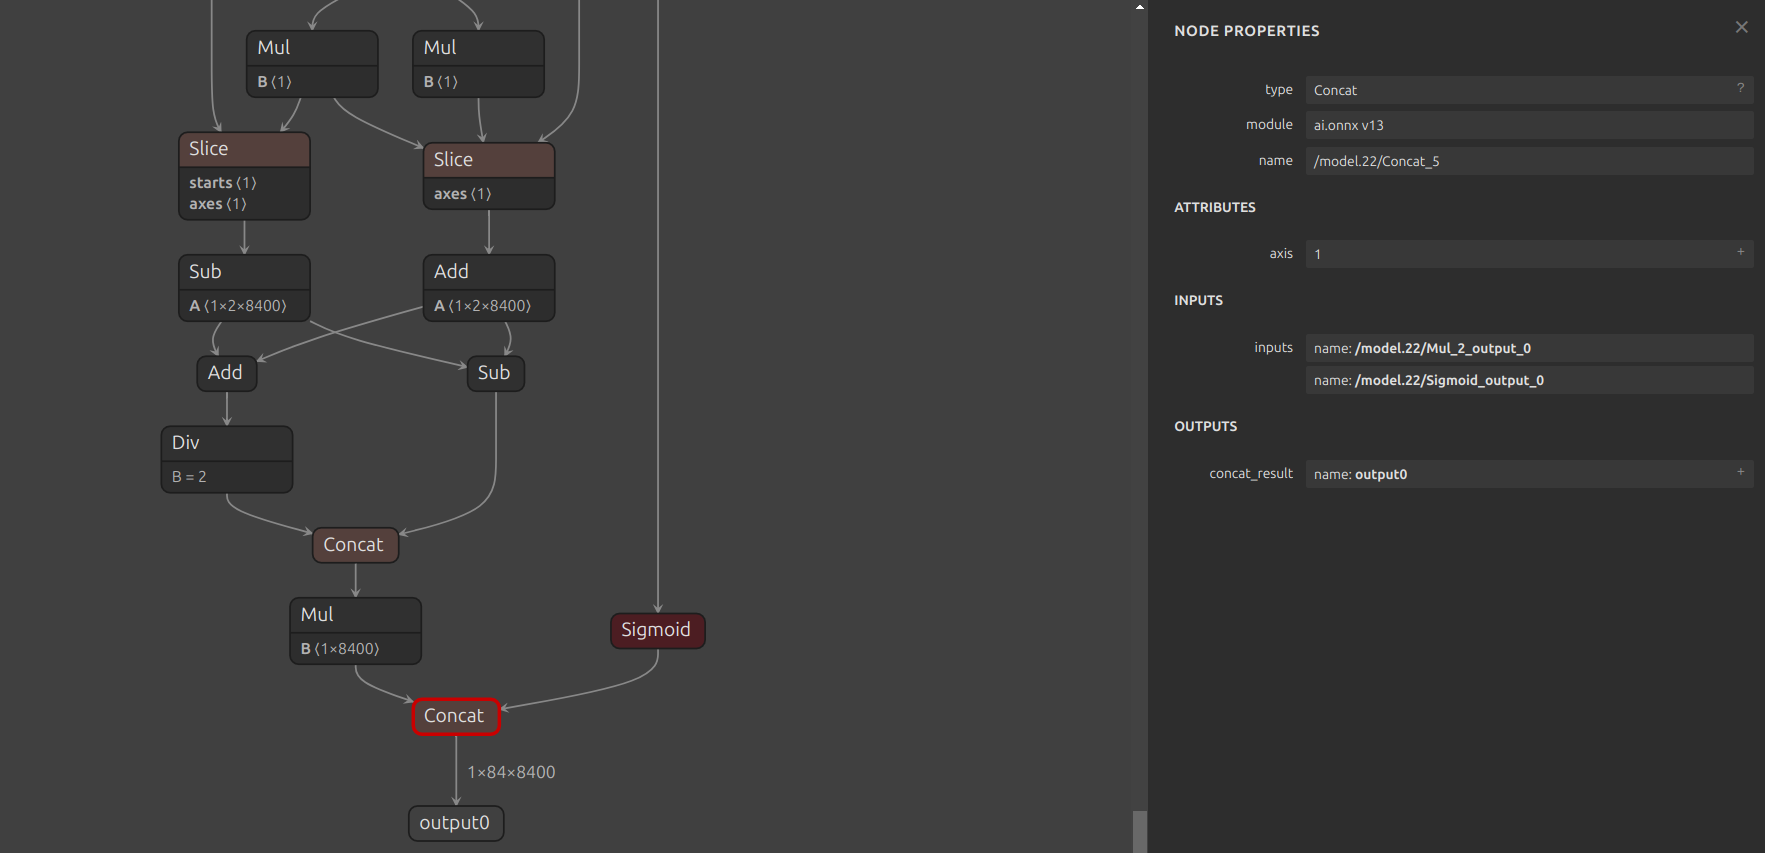

In [4]:
# Use the calibration_data_reader with quantize_static
quantize_static('models/pre.onnx', "models/static_quantized.onnx",
                weight_type=QuantType.QInt8,
                activation_type=QuantType.QUInt8,
                calibration_data_reader=calibration_data_reader,
                quant_format=QuantFormat.QDQ,
                nodes_to_exclude=['/model.22/Concat_3', '/model.22/Split', '/model.22/Sigmoid'
                                 '/model.22/dfl/Reshape', '/model.22/dfl/Transpose', '/model.22/dfl/Softmax', 
                                 '/model.22/dfl/conv/Conv', '/model.22/dfl/Reshape_1', '/model.22/Slice_1',
                                 '/model.22/Slice', '/model.22/Add_1', '/model.22/Sub', '/model.22/Div_1',
                                  '/model.22/Concat_4', '/model.22/Mul_2', '/model.22/Concat_5'],
                per_channel=False,
                reduce_range=True,)